# Assoziatonsanalyse

## Vorbereitung

Einlesen der Bibliotheken.

Hilfsfunktion zur Analyse der Eingabedatei

In [1]:
%reset -f

import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
# from mlxtend.frequent_patterns import apriori

In [5]:
def counting_items(df):
    """ 
    Get dataframe of items
    Show some statistics
    Ignore None-Entries
    """
    counting = df.to_numpy(dtype='str', na_value='nan')
    counting = counting.reshape(1,-1)
    unique, frequency = np.unique(counting,   return_counts = True)
    count = np.asarray((unique, frequency ))
    dfg= pd.DataFrame({'items':count[0], 'count':count[1].astype(int)}).sort_values(by = 'count', ascending=False)
    dfg = dfg[dfg['items']!= 'None'].reset_index(drop = True)
    dfg['support'] = dfg['count']/df.shape[0]
    r = len(dfg)
    c_items = 2**r
    c_itemsets = 3**r - 2**(r+1) + 1
    print(f'No of itemsets: {df.shape[0]}; no of different items: {r}, items comb. {c_items}, itemset comb. {c_itemsets}')
    display(dfg)
    return dfg['items'].tolist()


## Beispiel 1: Einführung

In [6]:
# Demo dataset

ldf = [
 ['Joghurt', 'Sahne'], ['Joghurt', 'Äpfel', 'Zwiebel'],
 ['Joghurt', 'Sahne', 'Äpfel'], ['Sahne'], ['Hering', 'Zwiebel'], 
 ['Äpfel', 'Joghurt', 'Zwiebel', 'Hering', 'Sahne']]


# check data

df_test = pd.DataFrame(ldf)
il = counting_items(df_test)

No of itemsets: 6; no of different items: 5, items comb. 32, itemset comb. 180


,items,count,support
0,Joghurt,4,0.666667
1,Sahne,4,0.666667
2,Zwiebel,3,0.500000
3,Äpfel,3,0.500000
4,Hering,2,0.333333


In [8]:
from itertools import combinations

ilc = []
for n in range(len(il) + 1):
    ilc += list(combinations(il, n))

print('No combination for itemsets: ', len(ilc))
print('Conbinations: ')
print(ilc)


No combination for itemsets:  32
Conbinations: 
[(), ('Joghurt',), ('Sahne',), ('Zwiebel',), ('Äpfel',), ('Hering',), ('Joghurt', 'Sahne'), ('Joghurt', 'Zwiebel'), ('Joghurt', 'Äpfel'), ('Joghurt', 'Hering'), ('Sahne', 'Zwiebel'), ('Sahne', 'Äpfel'), ('Sahne', 'Hering'), ('Zwiebel', 'Äpfel'), ('Zwiebel', 'Hering'), ('Äpfel', 'Hering'), ('Joghurt', 'Sahne', 'Zwiebel'), ('Joghurt', 'Sahne', 'Äpfel'), ('Joghurt', 'Sahne', 'Hering'), ('Joghurt', 'Zwiebel', 'Äpfel'), ('Joghurt', 'Zwiebel', 'Hering'), ('Joghurt', 'Äpfel', 'Hering'), ('Sahne', 'Zwiebel', 'Äpfel'), ('Sahne', 'Zwiebel', 'Hering'), ('Sahne', 'Äpfel', 'Hering'), ('Zwiebel', 'Äpfel', 'Hering'), ('Joghurt', 'Sahne', 'Zwiebel', 'Äpfel'), ('Joghurt', 'Sahne', 'Zwiebel', 'Hering'), ('Joghurt', 'Sahne', 'Äpfel', 'Hering'), ('Joghurt', 'Zwiebel', 'Äpfel', 'Hering'), ('Sahne', 'Zwiebel', 'Äpfel', 'Hering'), ('Joghurt', 'Sahne', 'Zwiebel', 'Äpfel', 'Hering')]


In [4]:
# Adapt list of lists for association analysis

encoder = TransactionEncoder()
encoded_array = encoder.fit(ldf).transform(ldf) 

print(encoded_array[:2])

df_itemsets = pd.DataFrame(encoded_array, columns=encoder.columns_)
df_itemsets

[[False  True  True False False]
 [False  True False  True  True]]


,Hering,Joghurt,Sahne,Zwiebel,Äpfel
0,False,True,True,False,False
1,False,True,False,True,True
2,False,True,True,False,True
3,False,False,True,False,False
4,True,False,False,True,False
5,True,True,True,True,True


In [5]:
# association analysis

min_support = 0.02 # 0.2 0.1
#frequent_itemsets = apriori(df_itemsets, min_support=min_support, use_colnames=True)
frequent_itemsets = fpgrowth(df_itemsets, min_support=min_support, use_colnames=True)

print(frequent_itemsets.shape)
display(frequent_itemsets.sort_values(by = 'support', ascending = False).head(5))
display(frequent_itemsets.sort_values(by = 'support', ascending = False).tail(5))

(31, 2)


,support,itemsets
0,0.666667,(Sahne)
1,0.666667,(Joghurt)
2,0.500000,(Äpfel)
3,0.500000,(Zwiebel)
5,0.500000,"(Joghurt, Sahne)"


,support,itemsets
17,0.166667,"(Äpfel, Hering)"
14,0.166667,"(Zwiebel, Joghurt, Sahne)"
13,0.166667,"(Äpfel, Zwiebel, Sahne)"
11,0.166667,"(Zwiebel, Sahne)"
30,0.166667,"(Zwiebel, Äpfel, Joghurt, Sahne, Hering)"


In [6]:
rules = association_rules(frequent_itemsets, 
                          metric="confidence", 
                          min_threshold=0.1).sort_values(by=['lift'], 
                                                         ascending=False)
print(rules.shape)
display(rules.iloc[:,0:7].head(4))
rules.iloc[:,0:7].tail(4)


(180, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
116,"(Zwiebel, Sahne)","(Äpfel, Hering)",0.166667,0.166667,0.166667,1.0,6.0
173,"(Hering, Joghurt)","(Äpfel, Zwiebel, Sahne)",0.166667,0.166667,0.166667,1.0,6.0
167,"(Zwiebel, Sahne)","(Äpfel, Hering, Joghurt)",0.166667,0.166667,0.166667,1.0,6.0
156,"(Äpfel, Zwiebel, Sahne)","(Hering, Joghurt)",0.166667,0.166667,0.166667,1.0,6.0


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
32,"(Joghurt, Sahne)",(Zwiebel),0.500000,0.500000,0.166667,0.333333,0.666667
33,(Zwiebel),"(Joghurt, Sahne)",0.500000,0.500000,0.166667,0.333333,0.666667
17,(Sahne),(Zwiebel),0.666667,0.500000,0.166667,0.250000,0.500000
16,(Zwiebel),(Sahne),0.500000,0.666667,0.166667,0.333333,0.500000


## Beispiel 2: Belegschaftsliste

Gibt es Paare von Personen, die gerne zusammen arbeiten oder gerade nicht?



In [7]:
# Read data

fn = 'assoc_data/assoc_demo.csv'
df = pd.read_csv(fn)
counting_items(df)

No of itemsets: 3200; no of different items: 20, items comb. 1048576, itemset comb. 3484687250


,items,count,support
0,Anna,800,0.25
1,Emily,800,0.25
2,Sophie,800,0.25
3,Paul,800,0.25
4,Niklas,800,0.25
5,Marie,800,0.25
6,Lukas,800,0.25
7,Luca,800,0.25
8,Louis,800,0.25
9,Leonie,800,0.25


In [8]:
#Convert to list of lists

ldf = df.values.tolist()  

# remove empty cells (not needed here)
ldf = [[x for x in line if x is not None] for line in ldf]
ldf[:5]

[['Anna', 'Leonie', 'Niklas', 'Louis', 'Lena'],
 ['Lara', 'Finn', 'Louis', 'Anna', 'Jonas'],
 ['Anna', 'Sophie', 'Jonas', 'Niklas', 'Laura'],
 ['Marie', 'Anna', 'Lukas', 'Niklas', 'Lara'],
 ['Finn', 'Tim', 'Laura', 'Sophie', 'Lea']]

In [9]:
encoder = TransactionEncoder()
encoded_array = encoder.fit(ldf).transform(ldf) 
df_itemsets = pd.DataFrame(encoded_array, columns=encoder.columns_)

print(df_itemsets.shape)
df_itemsets.head(3)

(3200, 20)


,Anna,Emily,Finn,Hannah,Jan,Jonas,Lara,Laura,Lea,Lena,Leon,Leonie,Louis,Luca,Lukas,Marie,Niklas,Paul,Sophie,Tim
0,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False
1,True,False,True,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False
2,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,True,False


In [10]:
frequent_itemsets = fpgrowth(df_itemsets, min_support=0.02, use_colnames=True) 

print(frequent_itemsets.shape)
display(frequent_itemsets.sort_values(by = 'support', ascending = False)[:10])


(210, 2)


,support,itemsets
0,0.25,(Lena)
11,0.25,(Marie)
1,0.25,(Leonie)
19,0.25,(Leon)
18,0.25,(Jan)
17,0.25,(Luca)
15,0.25,(Hannah)
14,0.25,(Emily)
13,0.25,(Lea)
12,0.25,(Tim)


In [11]:
rules = association_rules(frequent_itemsets, 
                          metric="confidence", 
                          min_threshold=0.005).sort_values(by=['lift'], 
                                                         ascending=False)
print(rules.shape)
display(rules.iloc[:4,[0,1,5,6]])
display(rules.iloc[-4:,[0,1,5,6]])
#display(rules)

(380, 9)


,antecedents,consequents,confidence,lift
200,(Leonie),(Lukas),0.37625,1.505
201,(Lukas),(Leonie),0.37625,1.505
160,(Lara),(Jonas),0.25000,1.000
161,(Jonas),(Lara),0.25000,1.000


,antecedents,consequents,confidence,lift
17,(Tim),(Lena),0.17375,0.695
16,(Lena),(Tim),0.17375,0.695
138,(Leon),(Anna),0.10375,0.415
139,(Anna),(Leon),0.10375,0.415


Lenonie und Lukas scheinen sich zu mögen, nicht so Leon und Anna.

## Beispiel 3: Warenkorbanalyse

In [12]:
# load data

fn = 'assoc_data/market_basket_optimisation.zip'
df = pd.read_csv(fn, header=None)
print(df.shape)
df.head(3)

(7501, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


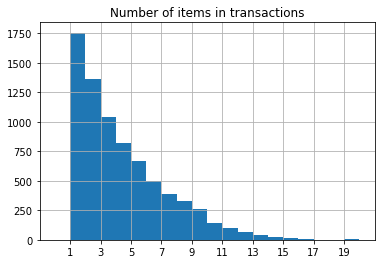

In [13]:
# check distribution of transaction sizes

ax = df.count(axis=1).hist(bins=20, range=[0,20])
ax.set_xticks(list(range(1,21,2)))
ax.set_title('Number of items in transactions');


In [14]:
# keep only  1 <  size of transactions < 12

print(df.shape)
dg = df.copy()
dg['count'] = df.count(axis=1)
df = df[(dg['count']>1) & (dg['count']<12)]
print(df.shape)

(7501, 20)
(5593, 20)


In [15]:
# statistics

counting_items(df)

No of itemsets: 5593; no of different items: 121, items comb. 2658455991569831745807614120560689152, itemset comb. 5391030899743293631234222576545675455702811654372431940900


,items,count,support
0,nan,86278,15.426068
1,mineral water,1597,0.285535
2,eggs,1209,0.216163
3,spaghetti,1158,0.207045
4,chocolate,1101,0.196853
...,...,...,...
116,bramble,9,0.001609
117,cream,5,0.000894
118,napkins,4,0.000715
119,water spray,3,0.000536


In [16]:
# convert to list of lists and drop empty values

ldf = df.values.tolist()  
ldf = [[x for x in line if not pd.isna(x)] for line in ldf]
ldf[100:103]

[['frozen vegetables', 'cooking oil', 'mashed potato'],
 ['frozen vegetables',
  'ground beef',
  'tomato sauce',
  'mineral water',
  'meatballs',
  'olive oil',
  'light cream',
  'tomato juice'],
 ['red wine',
  'spaghetti',
  'mineral water',
  'soup',
  'milk',
  'eggs',
  'cake',
  'gums',
  'cooking oil',
  'chocolate',
  'frozen smoothie']]

In [17]:
# one hot encode list of lists

encoder = TransactionEncoder()
encoded_array = encoder.fit(ldf).transform(ldf) 

df_itemsets = pd.DataFrame(encoded_array, columns=encoder.columns_)

print(df_itemsets.shape)
df_itemsets.head(3)

(5593, 120)


,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [18]:
# frequencies (support) of items
# set parameter "min_suport"
min_support = 0.05 # 0.01
frequent_itemsets = fpgrowth(df_itemsets, min_support=min_support, use_colnames=True) 

print(frequent_itemsets.shape)
display(frequent_itemsets.sort_values(by = 'support', ascending = False)[:10])


(33, 2)


,support,itemsets
3,0.285535,(mineral water)
0,0.216163,(eggs)
9,0.207045,(spaghetti)
14,0.196674,(chocolate)
7,0.195602,(french fries)
4,0.156267,(green tea)
5,0.153585,(milk)
23,0.117826,(ground beef)
10,0.113892,(frozen vegetables)
20,0.110495,(pancakes)


In [19]:
# find associations
# set parameter "metric" and "min_threshold"

rules = association_rules(frequent_itemsets, 
                          metric="confidence", 
                          min_threshold=0.01).sort_values(by=['lift'], 
                                                         ascending=False)
print(rules.shape)
display(rules.iloc[:10,:7])
display(rules.iloc[-10:,:7])
#display(rules.iloc[-4:,[0,1,5,6]])
#display(rules)

(8, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
2,(milk),(mineral water),0.153585,0.285535,0.055248,0.359721,1.259810
3,(mineral water),(milk),0.285535,0.153585,0.055248,0.193488,1.259810
4,(spaghetti),(mineral water),0.207045,0.285535,0.068836,0.332470,1.164373
5,(mineral water),(spaghetti),0.285535,0.207045,0.068836,0.241077,1.164373
6,(chocolate),(mineral water),0.196674,0.285535,0.065081,0.330909,1.158907
7,(mineral water),(chocolate),0.285535,0.196674,0.065081,0.227927,1.158907
0,(eggs),(mineral water),0.216163,0.285535,0.063293,0.292804,1.025456
1,(mineral water),(eggs),0.285535,0.216163,0.063293,0.221666,1.025456


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
2,(milk),(mineral water),0.153585,0.285535,0.055248,0.359721,1.259810
3,(mineral water),(milk),0.285535,0.153585,0.055248,0.193488,1.259810
4,(spaghetti),(mineral water),0.207045,0.285535,0.068836,0.332470,1.164373
5,(mineral water),(spaghetti),0.285535,0.207045,0.068836,0.241077,1.164373
6,(chocolate),(mineral water),0.196674,0.285535,0.065081,0.330909,1.158907
7,(mineral water),(chocolate),0.285535,0.196674,0.065081,0.227927,1.158907
0,(eggs),(mineral water),0.216163,0.285535,0.063293,0.292804,1.025456
1,(mineral water),(eggs),0.285535,0.216163,0.063293,0.221666,1.025456
